Importing libraries

In [1]:
import pytesseract

# Windows example path
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# Test installation
print(pytesseract.get_tesseract_version())

5.5.0.20241111


In [2]:
from dotenv import load_dotenv
import fitz  # PyMuPDF
import pytesseract
import cv2
from pdf2image import convert_from_path
from PIL import Image
import json
import os
import numpy as np
from google import genai
from dotenv import load_dotenv


# Load environment variables from .env file
load_dotenv()

# Access the variables
api_key = os.getenv("OPENROUTER_API_KEY")


Configuration

In [22]:
os.environ["PATH"] += os.pathsep + "/usr/bin" 
pytesseract.pytesseract.tesseract_cmd = "/usr/bin/tesseract"

DATA_DIR = r"C:\Users\Rafid\Desktop\Thesis_Nubedian\Document_anonymiser\data"
OUTPUT_DIR = r"C:\Users\Rafid\Desktop\Thesis_Nubedian\Document_anonymiser\redacted_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)


checking for pdfs

In [23]:
pdf_files = [f for f in os.listdir(DATA_DIR) if f.lower().endswith(".pdf")]

if pdf is readable text (not scanned copy)

In [26]:
def is_native_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    for page in doc:
        if page.get_text("words"):
            return True
    return False

print(is_native_pdf(os.path.join(DATA_DIR, pdf_files[1])))  # True = native, False = scanned


True


getting all the page content as text

In [28]:
import fitz  # PyMuPDF

pdf_path = os.path.join(DATA_DIR, pdf_files[1])

# Open PDF
doc = fitz.open(pdf_path)

# Extract text page by page
for page_number, page in enumerate(doc, start=1):
    text = page.get_text()  # full text of the page
    print(f"--- Page {page_number} ---")
    print(text)


--- Page 1 ---
MD RAFIDUL ISLAM 
AI, ML, NLP, COMPUTER VISION, DATA SCIENCE, AND SOFTWARE 
ENTHUSIASTS 
 
WORK EXPERIENCE 
NUBEDIAN GMBH, KARLSRUHE — BACHELOR THESIS 
JULY 2025 - CURRENT 
Multimodal LLM-driven PNG document parser 
▪ Implementing intelligent document parsing (PDFs, text, and 
images) with automated chunking, embeddings, and knowledge 
base integration via REST APIs. 
▪ Investigation of OCR techniques (EasyOCR, Tesseract) with 
preprocessing to improve accuracy. 
▪ Collaborating in an agile environment using modern technologies: 
Java, Rust, TypeScript, Node.js, React, and Kubernetes. 
 
NUBEDIAN GMBH, KARLSRUHE — AI INTERN 
DECEMBER 2024 - JUNE 2025 
▪ Development of a RAG chatbot: Fine-tuning a pre-trained LLM and 
integrating a Retrieval-Augmented Generation (RAG) pipeline to 
build an advanced chatbot for hospital management. 
▪ Agentic AI research: Researching and implementing agentic 
support functions using the Model Context Protocol (MCP) to 
improve the chatbot'

In [29]:
import os
import re
import json
from openrouter import OpenRouter

getting personal information list using llm

In [30]:
def find_pii_openrouter(text_content, model="gpt-4o-mini", base_url=None):
    from openrouter import OpenRouter
    import os, re, json

    client = OpenRouter(
        api_key=api_key
    )

    # Create prompt
    system_instruction = """
    You are a data anonymisation assistant.
    Identify PII (personal data) in the text.
    Examples: names, phone numbers, emails, addresses, ID numbers.
    Return ONLY a JSON array like this:
    [
        {"text": "John"},
        {"text": "Doe"},
        {"text": "johndoe@email.com"},
        ...
    ]
    Do not include features name like name, date of birth, insurance number, because they are not 
    sensitive information that should not be redacted.
    """

    messages = [
        {"role": "system", "content": system_instruction},
        {"role": "user", "content": text_content}
    ]

    response = client.chat.send(
        model="gpt-4o-mini",
        messages=messages
    )

    raw_content = response.choices[0].message.content
    # Strip code block if present
    cleaned = re.sub(r"^```json\s*|\s*```$", "", raw_content.strip(), flags=re.MULTILINE)
    try:
        pii = json.loads(cleaned)
    except json.JSONDecodeError:
        pii = []

    return pii


In [31]:
pii_list = find_pii_openrouter(text)

In [32]:
pii_list

[{'text': 'MD RAFIDUL ISLAM'},
 {'text': 'NUBEDIAN GMBH'},
 {'text': 'KARLSRUHE'},
 {'text': 'NUBEDIAN GMBH'},
 {'text': 'KARLSRUHE'},
 {'text': 'SCHANZER RACING E.V.'},
 {'text': 'INGOLSTADT'},
 {'text': 'MERCY STR 81'},
 {'text': '85051, INGOLSTADT'},
 {'text': '(49) 15753255867'},
 {'text': 'rafid.4507@gmail.com'},
 {'text': 'INGOLSTADT, GERMANY'},
 {'text': 'TECHNISCHE HOCHSCHULE INGOLSTADT'},
 {'text': 'SYLHET, BANGLADESCH'},
 {'text': 'SHAHJALAL UNIVERSITY OF SCIENCE AND TECHNOLOGY'}]

In [36]:
import fitz  # PyMuPDF
OUTPUT_DIR = "C:\\Users\\Rafid\\Desktop\\Thesis_Nubedian\\Document_anonymiser\\redacted_output"
def redact_by_text(pdf_path, pii_list):
    doc = fitz.open(pdf_path)

    for page in doc:
        for pii in pii_list:
            text = pii["text"]
            # Search all occurrences of text → get rectangles automatically
            areas = page.search_for(text)
            for rect in areas:
                page.add_redact_annot(rect, fill=(1,1,1))
        page.apply_redactions()

    base = os.path.basename(pdf_path).replace(".pdf", "_redacted.pdf")
    output_path = os.path.join(OUTPUT_DIR, base)

    doc.save(output_path)
    doc.close()

    return output_path

In [37]:
redacted_pdf = redact_by_text(os.path.join(DATA_DIR, pdf_files[1]), pii_list)

Conversion (PDF Page to Image)

In [39]:
import os
import time
from pathlib import Path
import pandas as pd
from typing import List, Dict, Any, Tuple
from pdf2image import convert_from_path
from PIL import Image


In [38]:
DPI = 300 # High DPI is crucial for accurate OCR
OUTPUT_DIR = "C:\\Users\\Rafid\\Desktop\\Thesis_Nubedian\\Document_anonymiser\\redacted_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

This step uses the pdf2image library to convert every page of the input PDF into a high-resolution PIL (Pillow) Image object.

In [40]:
def convert_scanned_pdf_to_images(pdf_path: Path, dpi: int = DPI) -> List[Image.Image]:
    """
    Converts each page of a PDF into a high-resolution PIL Image object.

    Args:
        pdf_path: The file path to the input PDF.
        dpi: Dots per inch for conversion (higher is better for OCR).

    Returns:
        A list of PIL Image objects, one for each page.
    """
    print(f"--- Starting Step 1: Converting '{pdf_path.name}' to images at {dpi} DPI ---")
    
    # Check if file exists before conversion
    if not pdf_path.exists():
        print(f"Error: PDF file not found at {pdf_path}")
        return []
        
    try:
        # pdf2image handles the heavy lifting
        images = convert_from_path(pdf_path, dpi=dpi)
        print(f"Successfully converted {len(images)} page(s) to images.")
        return images
    except Exception as e:
        print(f"Error during PDF to Image conversion. (Is Poppler installed?): {e}")
        return []


In [41]:
DATA_DIR = Path(r"C:\Users\Rafid\Desktop\Thesis_Nubedian\Document_anonymiser\data") 

# Use Path.glob to find the first file ending with .pdf in the data directory
# next() is used to get the first result, and 'None' is the default if no PDF is found.
first_pdf = next(DATA_DIR.glob("*.pdf"), None)

if first_pdf:
    TEST_PDF_PATH = first_pdf
    print(f"Found PDF to test: {TEST_PDF_PATH}")
else:
    # Fallback to the original placeholder if no PDF is found
    # NOTE: You MUST place a PDF in the 'data/' folder for this to succeed.
    TEST_PDF_PATH = Path("data/Medical Report with Barthel.pdf")
    print(f"WARNING: No PDF found in the '{DATA_DIR}' folder. Using fallback path: {TEST_PDF_PATH}")


Found PDF to test: C:\Users\Rafid\Desktop\Thesis_Nubedian\Document_anonymiser\data\Medical Report with Barthel.pdf


In [42]:
# Set this to the location of your Poppler bin folder
POPPLER_PATH = r"C:\Users\Rafid\Applications\Backend\poppler-25.11.0\Library\bin" 

# Other variables...
DPI = 300 

# The function definition
def convert_scanned_pdf_to_images(pdf_path: Path, dpi: int = DPI, poppler_path: str = POPPLER_PATH) -> List[Image.Image]:
    """
    Converts each page of a PDF into a high-resolution PIL Image object.

    Args:
        pdf_path: The file path to the input PDF.
        dpi: Dots per inch for conversion (higher is better for OCR).
        poppler_path: Explicit path to Poppler binaries (if not in PATH).

    Returns:
        A list of PIL Image objects, one for each page.
    """
    print(f"--- Starting Step 1: Converting '{pdf_path.name}' to images at {dpi} DPI ---")
    
    # Check if file exists before conversion
    if not pdf_path.exists():
        print(f"Error: PDF file not found at {pdf_path}")
        return []
        
    try:
        # Use poppler_path argument to explicitly tell pdf2image where to find the executables
        images = convert_from_path(pdf_path, dpi=dpi, poppler_path=poppler_path)
        print(f"Successfully converted {len(images)} page(s) to images.")
        return images
    except Exception as e:
        print(f"Error during PDF to Image conversion. (Is Poppler installed?): {e}")
        return []

In [43]:
images = convert_from_path(pdf_path, dpi=300, poppler_path=POPPLER_PATH)

In [44]:
print(f"Successfully converted {len(images)} page(s) to images.")

Successfully converted 1 page(s) to images.


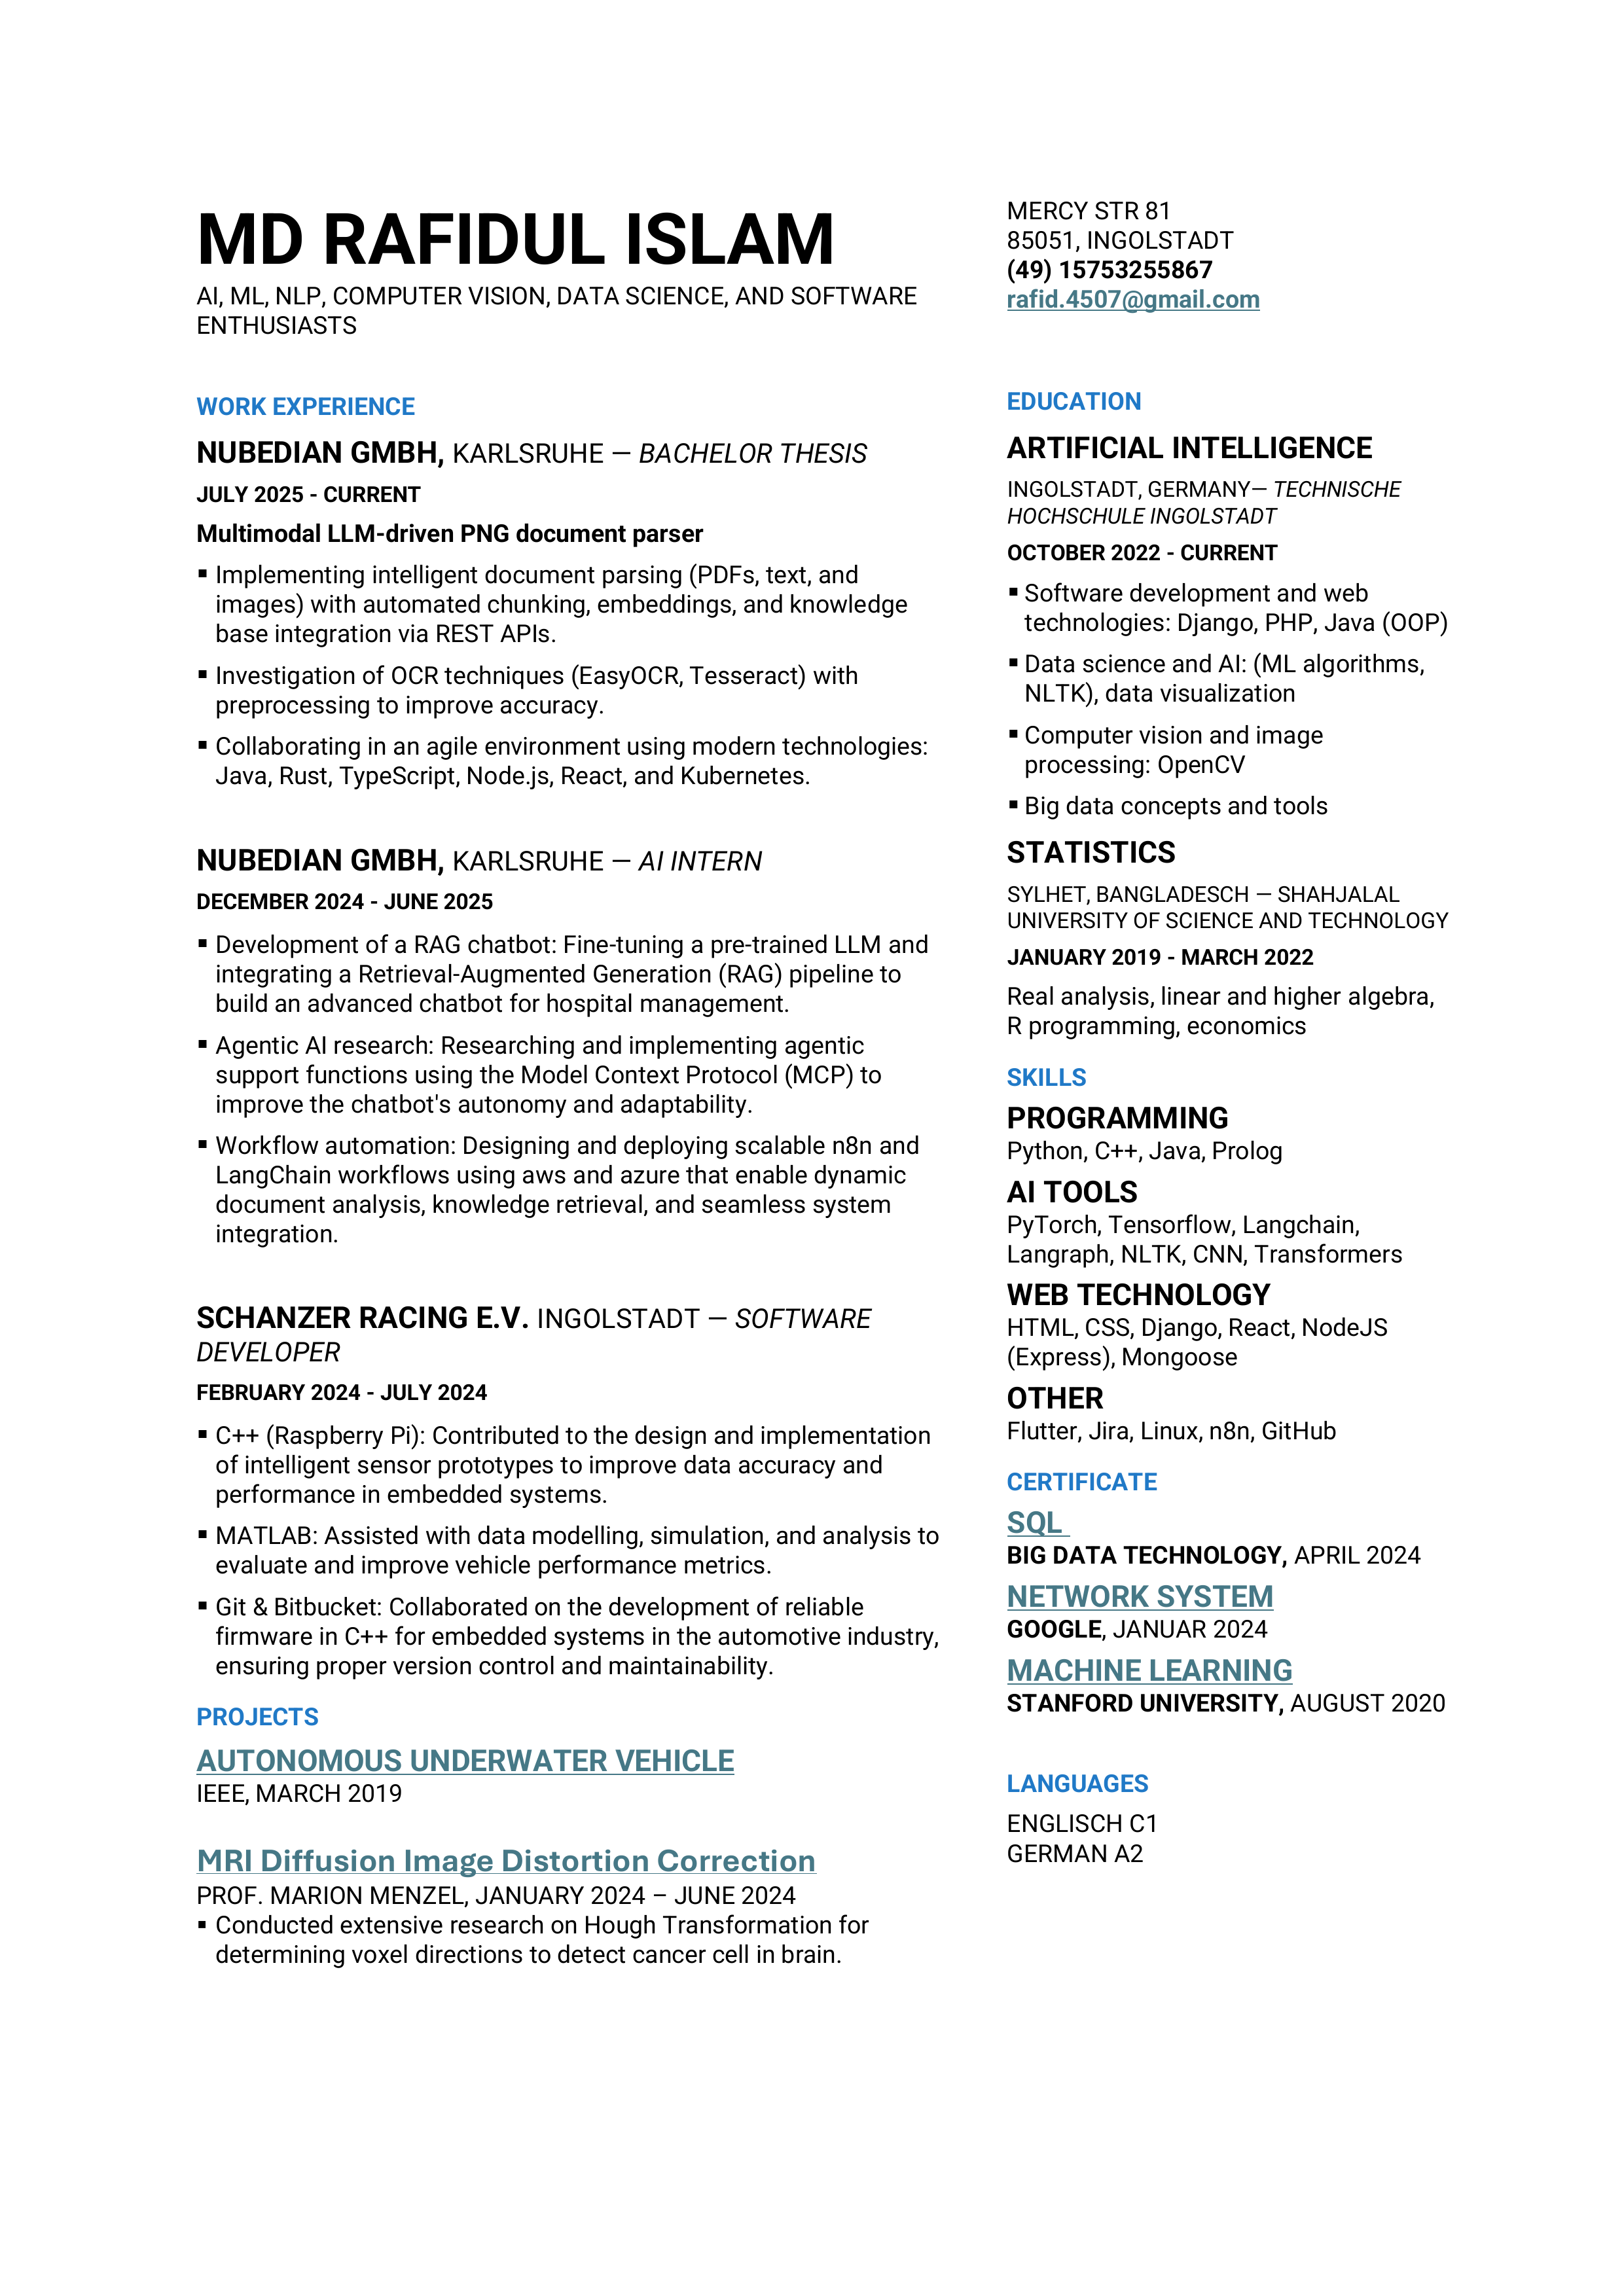

In [47]:
images[0]

In [ ]:
import pytesseract
from PIL import Image
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
# IMPORTANT: Uncomment and set this line if Tesseract is not in your system PATH
# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [ ]:
print(pytesseract.image_to_string(Image.open(images[0])))

In [ ]:
# This will store the extracted text and metadata for each page
ocr_data = [] 

for i, page_image in enumerate(images):
    print(f"--- Starting Step 2: Running OCR on Page {i+1} ---")
    
    # Example: Extract data including bounding boxes (output_type=pytesseract.Output.DICT)
    page_data = pytesseract.image_to_data(page_image, output_type=pytesseract.Output.DICT)
    
    ocr_data.append(page_data)
    
    print(f"Successfully extracted {len(page_data['text'])} text chunks from Page {i+1}.")

--- Starting Step 2: Running OCR on Page 1 ---


TesseractNotFoundError: /usr/bin/tesseract is not installed or it's not in your PATH. See README file for more information.

 Check the result

get the co ordinates


In [ ]:
def is_native_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    for page in doc:
        if page.get_text("words"):
            return True
    return False

def extract_native(pdf_path):
    doc = fitz.open(pdf_path)
    pages_data = []
    for page in doc:
        words = page.get_text("words")
        page_data = [{"text": w[4], "bbox": w[:4]} for w in words]
        pages_data.append(page_data)
    return pages_data

def extract_scanned(pdf_path):
    images = convert_from_path(pdf_path, poppler_path='/usr/bin')
    pages_data = []
    for img in images:
        img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        data = pytesseract.image_to_data(img_cv, output_type=pytesseract.Output.DICT)
        page_data = []
        for i in range(len(data["text"])):
            if data["text"][i].strip() != "":
                x, y, w, h = data["left"][i], data["top"][i], data["width"][i], data["height"][i]
                page_data.append({"text": data["text"][i], "bbox": [x, y, x+w, y+h]})
        pages_data.append(page_data)
    return pages_data, images

def analyze_pii(extracted_text):
    joined = "\n".join([item["text"] for page in extracted_text for item in page])
    client = genai.Client()
    system_instruction = """
    You are a data anonymisation assistant.
    Identify PII words or phrases from the text.
    Return ONLY a JSON array of objects: [{"text": "..."}]
    """
    response = client.models.generate_content(
        model="gemini-1.5-flash",
        contents=joined,
        system_instruction=system_instruction
    )
    try:
        return json.loads(response.text)
    except:
        return []

def redact_native(pdf_path, pii_list, extracted_data):
    doc = fitz.open(pdf_path)
    for page_no, page in enumerate(doc):
        page_words = extracted_data[page_no]
        for pii in pii_list:
            for w in page_words:
                if w["text"] == pii["text"]:
                    rect = fitz.Rect(*w["bbox"])
                    page.add_redact_annot(rect, fill=(0,0,0))
        page.apply_redactions()
    output = os.path.join(OUTPUT_DIR, os.path.splitext(os.path.basename(pdf_path))[0] + "_redacted.pdf")
    doc.save(output)
    return output

def redact_scanned(images, extracted_data, pii_list, pdf_name):
    redacted_images = []
    for i, img in enumerate(images):
        img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        page_words = extracted_data[i]
        for pii in pii_list:
            for w in page_words:
                if w["text"] == pii["text"]:
                    x1, y1, x2, y2 = w["bbox"]
                    cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0,0,0), -1)
        redacted_images.append(Image.fromarray(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)))
    output_path = os.path.join(OUTPUT_DIR, pdf_name + "_redacted.pdf")
    redacted_images[0].save(output_path, save_all=True, append_images=redacted_images[1:])
    return output_path


In [ ]:

if not pdf_files:
    print("No PDF files found in 'data/' folder.")
else:
    for pdf in pdf_files:
        input_path = os.path.join(DATA_DIR, pdf)
        print(f"Processing: {input_path}")
        if is_native_pdf(input_path):
            print(" → Detected Native PDF")
            extracted = extract_native(input_path)
            pii = analyze_pii(extracted)
            output = redact_native(input_path, pii, extracted)
        else:
            print(" → Detected Scanned PDF")
            extracted, images = extract_scanned(input_path)
            pii = analyze_pii(extracted)
            output = redact_scanned(images, extracted, pii, os.path.splitext(pdf)[0])
        print(f" ✔ Saved: {output}\n")

Processing: C:\Users\Rafid\Desktop\Thesis_Nubedian\Document_anonymiser\data\Medical Report with Barthel.pdf
 → Detected Native PDF


ValueError: Missing key inputs argument! To use the Google AI API,provide (`api_key`) arguments. To use the Google Cloud API, provide (`vertexai`, `project` & `location`) arguments.

In [ ]:
# ---------------------------
# Process PDFs in data folder
# ---------------------------
pdf_files = [f for f in os.listdir(DATA_DIR) if f.lower().endswith(".pdf")]

if not pdf_files:
    print("No PDF files found in 'data/' folder.")
else:
    for pdf in pdf_files:
        input_path = os.path.join(DATA_DIR, pdf)
        print(f"Processing: {input_path}")
        if is_native_pdf(input_path):
            print(" → Detected Native PDF")
            extracted = extract_native(input_path)
            pii = analyze_pii(extracted)
            output = redact_native(input_path, pii, extracted)
        else:
            print(" → Detected Scanned PDF")
            extracted, images = extract_scanned(input_path)
            pii = analyze_pii(extracted)
            output = redact_scanned(images, extracted, pii, os.path.splitext(pdf)[0])
        print(f" ✔ Saved: {output}\n")